In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
spam_data = np.array(pd.read_csv("../Datasets/spam.csv"))

cancer_data = np.array(pd.read_csv("../Datasets/cancer.csv"))

for i in range(len(cancer_data)):
    label = cancer_data[i][0]
    for j in range(1, len(cancer_data[i])):
        cancer_data[i][j - 1] = cancer_data[i][j]
    cancer_data[i][-1] = 0 if (label == 'B') else 1

# Task 7

In [111]:
def calculate_auc(points):
    points.sort(key = lambda p: p[0])
    
    result = 0
    
    for i in range(1, len(points)):
        result = result + (points[i][0] - points[i - 1][0]) * (points[i - 1][1] + points[i][1]) / 2.0
        # may also take left value instead of calculating average
        
    return result

def normalize_point(point):
    if (point[0] - point[1] > 0): # under diagonal
        return [1 - point[0], 1 - point[1]]
    return point

def auc_point(tp, fp, tn, fn):
    false_positive = fp / (fp + tn)
    true_positive = tp / (tp + fn)
        
    return normalize_point([false_positive, true_positive])

def top_roc_curves(data):
    data = list(data)
    features_number = len(data[0]) - 1
    variants = []
    for f in range(features_number):
        points = [[0, 0], [1, 1]]
        
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        # initially all labels are 0
        for i in range(len(data)):
            if (data[i][-1] == 0):
                tn = tn + 1
            else:
                fn = fn + 1
                
        points.append(auc_point(tp, fp, tn, fn))        
        data.sort(key = lambda x: x[f])        
            
        # labels become 1 from left to right        
        for i in range(len(data)):
            if (data[i][-1] == 0):
                tn = tn - 1
                fp = fp + 1
            else:
                fn = fn - 1
                tp = tp + 1
            if (i + 1 == len(data) or data[i][f] != data[i + 1][f]): # can be splitted here  
                points.append(auc_point(tp, fp, tn, fn))
        
        variants.append([calculate_auc(points), points, f]) 
        
    variants.sort(key = lambda x: -x[0])
    return variants  
     

In [112]:
def draw_curve(points):
    points.sort(key = lambda p: p[0])
    plt.close()
    
    plt.plot([x[0] for x in points], [x[1] for x in points])
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()

Cancer data
0-th feature is 22
AUC is 0.9745652978172397


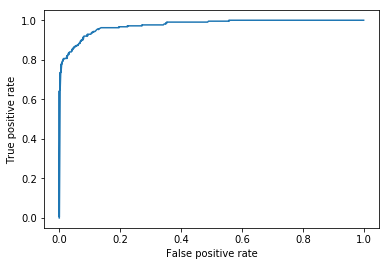

1-th feature is 20
AUC is 0.969643517784472


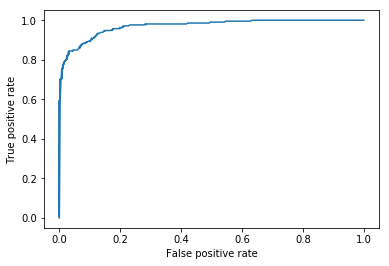

2-th feature is 23
AUC is 0.9689828761693358


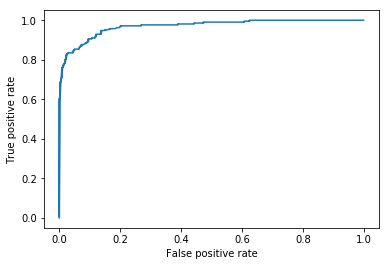

In [113]:
curves = top_roc_curves(cancer_data)
print("Cancer data")
for i in range(3):
    print(str(i) + "-th feature is " + str(curves[i][2]))
    print("AUC is " + str(curves[i][0]))
    draw_curve(curves[i][1])  

Spam data
0-th feature is 51
AUC is 0.8286336287975968


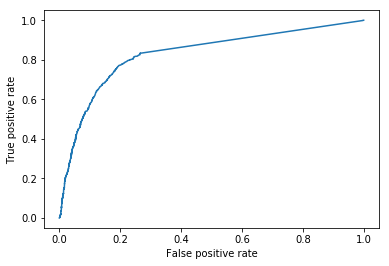

1-th feature is 55
AUC is 0.8041352664994804


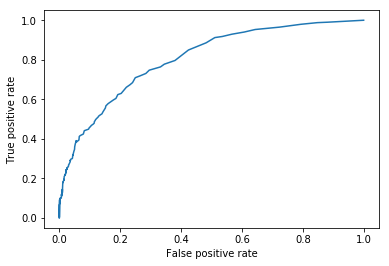

2-th feature is 54
AUC is 0.7881931942190192


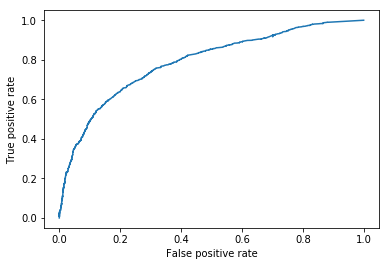

In [114]:
curves = top_roc_curves(spam_data)
print("Spam data")
for i in range(3):
    print(str(i) + "-th feature is " + str(curves[i][2]))
    print("AUC is " + str(curves[i][0]))
    draw_curve(curves[i][1])    

51-th feature has lots of equal values, so there is a gap between false positive rate 0.28 and 1.0 (becase we can not classify differently points with the same values of that feature).
If I calculated auc with taking not average between adjacent points but true positive rate in the left point then 51-th feature would be worse than others.
Hovewer, calculating average is quite nice because we can get all the points in a segment between two known points by randomizing them with different probabilities.

# Task 8

In [3]:
def split_data(data):
    training_data = []
    validation_data = []
    
    validation_size = len(data) * 0.2
    
    training_data.extend(data)
    
    while (len(validation_data) < validation_size):
        r = np.random.randint(0, len(training_data))
        validation_data.append(training_data[r])
        training_data.pop(r)
        
    return (np.array(training_data), np.array(validation_data))    

In [4]:
def examine(data):
    n = len(data)
    m = 0
    
    for i in range(len(data)):
        if (data[i][-1] == 1):
            m = m + 1
    print("Percentage of class 1 in data is " + str(m / float(n)))        

In [14]:
training_spam_data, validation_spam_data = split_data(spam_data)
print("Training data:")
examine(training_spam_data)
print("Validation data:")
examine(validation_spam_data)

Training data:
Percentage of class 1 in data is 0.39402173913043476
Validation data:
Percentage of class 1 in data is 0.3941368078175896


In [168]:
training_cancer_data, validation_cancer_data = split_data(cancer_data)
print("Training data:")
examine(training_cancer_data)
print("Validation data:")
examine(validation_cancer_data)

Training data:
Percentage of class 1 in data is 0.367032967032967
Validation data:
Percentage of class 1 in data is 0.39473684210526316


# Task 9

In [167]:
class DecisionTreeNode:
    def __init__(self):
        self.threshold_function = None # if true then go to the right node
        self.left = None
        self.right = None
        self.positive_class_probability = 0

def top_tree(trees, data):
    segments = 300
    variants = []
    
    positive = 0
    negative = 0
    
    for x in data:
        if (x[-1] == 1):
            positive = positive + 1
        else:
            negative = negative + 1
    
    for t in range(len(trees)):
        tree = trees[t]
        points = [[0, 0], [1, 1]]
        
        data_probabilities = []
        for x in data:
            data_probabilities.append([calculate_probability(x, tree), x[-1]])
        
        data_probabilities.sort(key = lambda x: -x[0])
        
        current_point = [0, 0]
        
        for x in data_probabilities:
            if (x[1] == 1):
                current_point[1] = current_point[1] + 1.0 / positive
            else:
                current_point[0] = current_point[0] + 1.0 / negative
            
            points.append(current_point.copy())
            
        variants.append([calculate_auc(points), points, t])
    
    variants.sort(key = lambda x: -x[0])
    
    return variants
        
def positive_probability(data):
    num = 0
    for x in data:
        if (x[-1] == 1):
            num = num + 1
    return num / float(len(data))   

def gini_impurity(positive, negative):
    return 2.0 * (positive * negative) / float(positive + negative) ** 2
    
# no division on |x_total|, because doesnt change anything    
def information_gain(lp, ln, rp, rn):
    left_num = lp + ln
    right_num = rp + rn
    
    if (left_num == 0 or right_num == 0):
        return 0 # no information gain.
    
    node_num = left_num + right_num
    
    result = gini_impurity(lp + rp, ln + rn) * node_num 
    
    result = result - gini_impurity(lp, ln) * left_num
    result = result - gini_impurity(rp, rn) * right_num
    return result
    
def split_by_threshold(data, threshold_function):
    left_data = []
    right_data = []
    
    for x in data:
        if (threshold_function(x)):
            right_data.append(x)
        else:
            left_data.append(x)
            
    return (left_data, right_data)
    
def build_decision_tree(data, level):
    result = DecisionTreeNode()
    
    if (level == 0):
        result.positive_class_probability = positive_probability(data)
        return result
    
    if (not data is list):
        data = list(data)
        
    features_number = len(data[0]) - 1
    
    best_ig = 0
    threshold_function = None
    
    for f in range(features_number):
        lp = 0 # left positive
        ln = 0 # left negative
        rp = 0 # right positive
        rn = 0 # right negative

        for x in data:
            if (x[-1] == 1):
                lp = lp + 1
            else:
                ln = ln + 1
                
        data.sort(key = lambda x: x[f])        
                    
        for i in range(len(data)): 
            if (data[i][-1] == 1):
                rp = rp + 1
                lp = lp - 1
            else:
                rn = rn + 1
                ln = ln - 1
            
            ig = information_gain(lp, ln, rp, rn)
            
            if (i + 1 == len(data) or data[i][f] != data[i + 1][f]): # can split here
                if (ig > 0 and ig > best_ig):
                    best_ig = ig
                    threshold = data[i][f]
                    threshold_function = lambda x, threshold=threshold, f=f: x[f] <= threshold
                                  
    if (best_ig == 0):
        result.positive_class_probability = positive_probability(data)
        return result

    left_data, right_data = split_by_threshold(data, threshold_function)
    result.threshold_function = threshold_function
    result.left = build_decision_tree(left_data, level - 1)
    result.right = build_decision_tree(right_data, level - 1)
    
    return result

def calculate_probability(x, tree):
    if (tree.threshold_function is None):
        return tree.positive_class_probability
    
    if (tree.threshold_function(x)):
        return calculate_probability(x, tree.right)
    else:
        return calculate_probability(x, tree.left)
        

Cancer data
Best AUC is 0.9719806763285026
Level of the best tree is 4
Validation error for the tree of level 4 is 0.9719806763285026
Validation error for the tree of level 3 is 0.9716586151368762
Validation error for the tree of level 2 is 0.9665056360708536
Validation error for the tree of level 5 is 0.9165861513687611
Validation error for the tree of level 6 is 0.9165861513687611
Validation error for the tree of level 7 is 0.9165861513687611
Validation error for the tree of level 8 is 0.9165861513687611
Validation error for the tree of level 9 is 0.9165861513687611
Validation error for the tree of level 10 is 0.9165861513687611
Validation error for the tree of level 1 is 0.8512077294685991
ROC curve for the best tree:


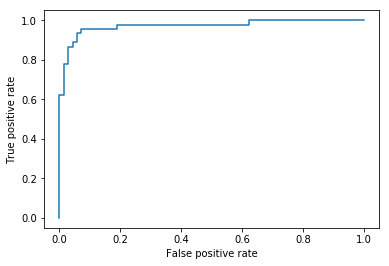

In [172]:
trees = []
for level in range(1, 11):
    trees.append(build_decision_tree(training_cancer_data, level))
    
variants = top_tree(trees, validation_cancer_data)
print("Cancer data")
print("Best AUC is " + str(variants[0][0]))
print("Level of the best tree is " + str(variants[0][2] + 1))
for i in range(10):
    print("Validation error for the tree of level " + str(variants[i][2] + 1) + " is " + str(variants[i][0]))
    
print("ROC curve for the best tree:")    
draw_curve(variants[0][1])  

Spam data
Best AUC is 0.9216357119583006
Level of the best tree is 7
Validation error for the tree of level 7 is 0.9216357119583006
Validation error for the tree of level 5 is 0.9167086307848834
Validation error for the tree of level 4 is 0.9161112592197721
Validation error for the tree of level 8 is 0.9157854201842535
Validation error for the tree of level 6 is 0.9149708225954624
Validation error for the tree of level 9 is 0.9098610740839553
Validation error for the tree of level 3 is 0.9033985998795466
Validation error for the tree of level 10 is 0.9001698312548838
Validation error for the tree of level 2 is 0.8256366203580333
Validation error for the tree of level 1 is 0.733829003623731
ROC curve for the best tree:


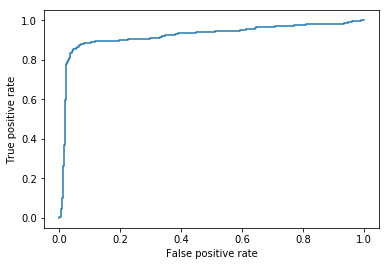

In [173]:
trees = []
for level in range(1, 11):
    trees.append(build_decision_tree(training_spam_data, level))
    
variants = top_tree(trees, validation_spam_data)
print("Spam data")
print("Best AUC is " + str(variants[0][0]))
print("Level of the best tree is " + str(variants[0][2] + 1))
for i in range(10):
    print("Validation error for the tree of level " + str(variants[i][2] + 1) + " is " + str(variants[i][0]))
    
print("ROC curve for the best tree:")    
draw_curve(variants[0][1]) 

After level 7 our tree becomes overtrained